In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from ewstools import core
import itertools

In [2]:
# set your path
path_from = "/Users/liqingchun/Google Drive/Dissertation/Paper/Journal/Early Warning/Evelyn_results/Covid-Early-Warning/Filtered-Time-Series-Data/Houston/"
path_written_to = "/Users/liqingchun/Google Drive/Dissertation/Paper/Journal/Early Warning/Evelyn_results/Covid-Early-Warning/results/Houston/"

In [3]:
cityname = "Houston"

In [4]:
input_jan = "houston-time-series-Jan-new.csv"
input_feb = "houston-time-series-Feb-new.csv"
input_mar = "houston-time-series-Mar-new.csv"

In [5]:
# first case, death, shelter in place

first_case = "Mar. 4th"
first_death = "Mar. 26th"
shelter = "Mar. 24th"

# start from zero, since the graph has zero
case_num = 31 + 29 + 4 - 1
death_num = 31 + 29 + 26 - 1
shelter_num = 31 + 29 + 24 - 1

In [6]:
# set the starting value, ending value and step for bandwidth and rowing window
bw_start = 20
bw_end = 90
bw_step = 2
bw_number = 36

rw_start = 0.2
rw_end = 0.5
rw_step = 0.01
rw_number = 31


# move forward
span = 0.25
lags = [1] 
ews = ['sd','ac'] 

In [7]:
os.chdir(path_from)
os.getcwd()

'/Users/liqingchun/Google Drive/Dissertation/Paper/Journal/Early Warning/Evelyn_results/Covid-Early-Warning/Filtered-Time-Series-Data/Houston'

In [8]:
# read
df1 = pd.read_csv(input_jan)
print(df1.columns)

Index(['Unnamed: 0', 'Date', 'Essential', 'NonEssential'], dtype='object')


In [9]:
# drop the index column
df1 = df1.drop('Unnamed: 0',axis=1)

In [10]:
# schema of the data frame
df1

,Date,Essential,NonEssential
0,2020-01-01,62673,224117
1,2020-01-02,103656,324137
2,2020-01-03,113238,378389
3,2020-01-04,94004,359244
4,2020-01-05,86101,305065
5,2020-01-06,114621,344633
6,2020-01-07,119665,361359
7,2020-01-08,122657,372912
8,2020-01-09,123345,379399
9,2020-01-10,126357,397160


In [11]:
df2 = pd.read_csv(input_feb)
df2 = df2.drop('Unnamed: 0',axis=1)
df3 = pd.read_csv(input_mar)
df3 = df3.drop('Unnamed: 0',axis=1)
print(df2.shape)
print(df3.shape)

(29, 3)
(31, 3)


In [12]:
# combine
cityWhole = pd.concat([df1,df2,df3],ignore_index=True)
cityWhole

,Date,Essential,NonEssential
0,2020-01-01,62673,224117
1,2020-01-02,103656,324137
2,2020-01-03,113238,378389
3,2020-01-04,94004,359244
4,2020-01-05,86101,305065
...,...,...,...
86,2020-03-27,51996,126291
87,2020-03-28,45841,111178
88,2020-03-29,63862,213990
89,2020-03-30,52804,127620


In [66]:
baseline = cityWhole.loc[16:36,:].set_index('Date').loc[:,'Essential':'NonEssential']
temp_avr = baseline.values.reshape(-1,7,2).mean(axis=1)

temp_avr = temp_avr.mean(axis=0)

#temp_avr

perc_change = cityWhole.loc[37:85,:].set_index('Date').loc[:,'Essential':'NonEssential']
perc_change_mean = perc_change.values.reshape(-1,7,2).mean(axis=1)

#perc_change_mean

temp_result = (temp_avr - perc_change_mean)/temp_avr

#temp_result

print(temp_result[3])
print(temp_result[-1])

[0.18354984 0.11234676]
[0.45522407 0.59931912]


In [13]:
total_days = len(cityWhole)
print(total_days)
cityWhole.index

91


RangeIndex(start=0, stop=91, step=1)

In [14]:
# create two list of possible rowing-window values and band-width values, put them into list to feed into itertools functions
rw = list(np.linspace(rw_start,rw_end,rw_number, endpoint=True))
bw = list(np.linspace(bw_start,bw_end,bw_number, endpoint=True))
list1 = [rw,bw]

In [15]:
bw

[20.0,
 22.0,
 24.0,
 26.0,
 28.0,
 30.0,
 32.0,
 34.0,
 36.0,
 38.0,
 40.0,
 42.0,
 44.0,
 46.0,
 48.0,
 50.0,
 52.0,
 54.0,
 56.0,
 58.0,
 60.0,
 62.0,
 64.0,
 66.0,
 68.0,
 70.0,
 72.0,
 74.0,
 76.0,
 78.0,
 80.0,
 82.0,
 84.0,
 86.0,
 88.0,
 90.0]

In [16]:
# generate a list of tuples that contains (rowing-window-value,bandwidth-value) pairs
prod = itertools.product(*list1)
TupList = []
for i in prod:
    TupList.append(i)

In [17]:
TupList[0]

(0.2, 20.0)

In [18]:
# create 2 new lists to store all values of std and all values of lag-1AC
storage_std = np.array([])
storage_lag = np.array([])

In [19]:
# for each (rowing-window,bandwidth) pair, compute the ews dataframe, store the corresponding kendall tau value of std into storage_std, and store the corresponding kendall tau value of lag into storage_lag
for i in range(len(TupList)):
    ews_dic = core.ews_compute(cityWhole["Essential"], roll_window = TupList[i][0],smooth ='Gaussian',band_width= TupList[i][1],span = span,lag_times = [1], ews = ews,upto = 'Full')
    if i != 0: # exclude the first item since they are NoneType objects and this will make the entire array to be type "object" if include them
        storage_std = np.append(storage_std,ews_dic['Kendall tau']["Standard deviation"][0]) # pandas series with 1 element, so index 0
        storage_lag = np.append(storage_lag, ews_dic['Kendall tau']["Lag-1 AC"][0]) # pandas series with 1 element, so index 0

In [20]:
# print out the max kendall tau for std and lagAC for comparison
max_std = np.amax(storage_std)
max_lag = np.amax(storage_lag)
print(max_std)
print(max_lag)

0.09462915601023017
0.5309779825908857


In [21]:
print(len(TupList))
print(len(storage_std))
print(len(storage_lag))

1116
1115
1115


##### Add one when locating the tuple in TupList since the first item is "None Type" in tupList and we did not store that in storage_std and storage_lag

In [22]:
# find the location/index of maximum std in the storage_std, and use the index to find the corresponding rowing-window and bandwidth
print("*** max std located in pair ***")
max_std_index = np.where(storage_std == max_std)
print("index at : " + str(max_std_index[0]+1) + "in TupList")
# store the tuple for comparison
target_pair_std = TupList[max_std_index[0][0]+1]
print("tuple (rowing-windows,bandwidth): " + str(target_pair_std))
print("largest std kendall tau: " + str(max_std))

*** max std located in pair ***
index at : [242]in TupList
tuple (rowing-windows,bandwidth): (0.26, 72.0)
largest std kendall tau: 0.09462915601023017


In [23]:
# some mechanism to find the index of maximum lagAC and the corresponding tuple
print("*** max lag located in pair ***")
max_lag_index = np.where(storage_lag == max_lag)
print("index at : " + str(max_lag_index[0]+1) + "in TupList")
# store the tuple for comparison
target_pair_lag = TupList[max_lag_index[0][0]+1]
print("tuple (rowing-windows,bandwidth): " + str(target_pair_lag))
print("largest lag kendall tau: " + str(max_lag))

*** max lag located in pair ***
index at : [432]in TupList
tuple (rowing-windows,bandwidth): (0.32, 20.0)
largest lag kendall tau: 0.5309779825908857


In [24]:
# create an empty tuple, the tuple that contains larger Kendall Tau value will be selected
# select either AC max tuple or Standard Deviation max tuple automatically
selected_pair = ()
if (max_lag > max_std):
    selected_pair = target_pair_lag
    print("lagAC larger, select " + str(target_pair_lag))
elif(max_lag < max_std):
    selected_pair = target_pair_std
    print("std larger, select " + str(target_pair_std))
else:
    print("rare case!")
    selected_pair = target_pair_std

lagAC larger, select (0.32, 20.0)


In [25]:
# double check, print out
#setRW = selected_pair[0]
#setBW = selected_pair[1]
setRW = target_pair_std[0]
setBW = target_pair_std[1]
print("setRW : " + str(setRW))
print("setBW : " + str(setBW))

ews_dic_std = core.ews_compute(cityWhole["Essential"], 
                          roll_window = setRW,
                           smooth ='Gaussian',
                           band_width= setBW,
                          span = span,
                          lag_times = [1], 
                          ews = ews,
                          upto = 'Full')

setRW : 0.26
setBW : 72.0


In [26]:
# double check, print out
#setRW = selected_pair[0]
#setBW = selected_pair[1]
setRW = target_pair_lag[0]
setBW = target_pair_lag[1]
print("setRW : " + str(setRW))
print("setBW : " + str(setBW))

ews_dic_lag = core.ews_compute(cityWhole["Essential"], 
                          roll_window = setRW,
                           smooth ='Gaussian',
                           band_width= setBW,
                          span = span,
                          lag_times = [1], 
                          ews = ews,
                          upto = 'Full')

setRW : 0.32
setBW : 20.0


In [27]:
# double check, print out
setRW = selected_pair[0]
setBW = selected_pair[1]
print("setRW : " + str(setRW))
print("setBW : " + str(setBW))

ews_dic = core.ews_compute(cityWhole["Essential"], 
                          roll_window = setRW,
                           smooth ='Gaussian',
                           band_width= setBW,
                          span = span,
                          lag_times = [1], 
                          ews = ews,
                          upto = 'Full')

setRW : 0.32
setBW : 20.0


In [28]:
# dfs
df_ews_std = ews_dic_std['EWS metrics']
df_ktau_std = ews_dic_std['Kendall tau']

df_ews_lag = ews_dic_lag['EWS metrics']
df_ktau_lag = ews_dic_lag['Kendall tau']

df_ews = ews_dic['EWS metrics']

In [29]:
# different cities needs adjustment of the location of annotation since total number varies
# set to mean, so location set automatically

# location of annotation for the 1st graph
annotation_location_1 = np.mean(df_ews[["State variable"]])
annotation_location_2 = np.mean(df_ews[["Residuals"]])
# location of annotations for the 2nd graph
annotation_location_3 = np.mean(df_ews_std["Standard deviation"])
# location of annotations for the 3rd graph
annotation_location_4 = np.mean(df_ews_lag["Lag-1 AC"])

In [45]:
# 2 parameter: you may want to change these two
LegendTF = False
generateNow = True

# set the early warning (gray)band using the variables below 

# Action Required: the start and the end of band in first graph
bar_start_1 = 45 # need modification
bar_end_1 = 47 # need modification


# Action Required: the start and the end of band in 2nd graph
bar_start_2 = 55 # need modification
bar_end_2 = 57 # need modification


# Action Required: the start and the end of band in 3rd graph
bar_start_3 = 59 # need modification
bar_end_3 = 61 # need modification

In [46]:
cityWhole.loc[59]

Date            2020-02-29
Essential            63990
NonEssential        258206
Name: 59, dtype: object

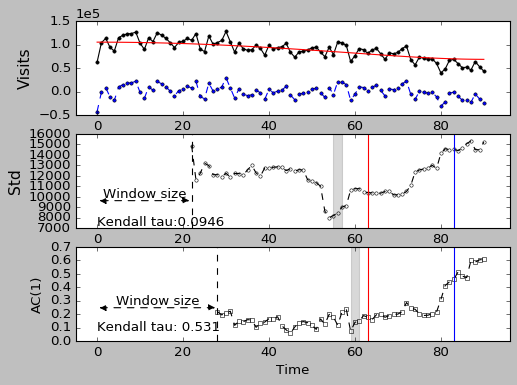

In [47]:
# the dates and string of first case, first death , shelter in place order are set at the beginning in the notebook
# parameter needs to be set are in the previous cell


# constant, you don't need to change them, but if you want to you can change ALPHA OR DIST 
ALPHA = 0.3
DIST = 5
ZERO = 0
NROWS = 3
NCOLS = 1
windown_position_std = int(target_pair_std[0]*total_days-1)
windown_position_lag = int(target_pair_lag[0]*total_days-1)
# title = ("Essential Early warning signals for city " + cityname)
# No action require below
plt.style.use('classic')
fig1, axes = plt.subplots(nrows = NROWS, ncols = NCOLS, figsize=(7,5))
df_ews[['State variable']].plot(ax=axes[0], 
        color='black', xlim = (-DIST,total_days + DIST),legend = LegendTF,
        marker='o', markersize=3) # frame auto set
df_ews[['Smoothing']].plot(ax=axes[0], color='red', xlim = (-DIST,total_days + DIST),legend = LegendTF)
df_ews[['Residuals']].plot(ax=axes[0], color='blue', xlim = (-DIST,total_days + DIST),legend = LegendTF,
                            marker='o', markersize=3, linestyle='dashed') # frame auto set
#axes[0].axvline(x = case_num, color='red', label='First case')
#axes[0].axvline(x = death_num, color='yellow')
#axes[0].axvline(x = shelter_num, color='yellow', label='Shelter in place')
#axes[0].annotate('First Case' +'\n'+ first_case, xy=((case_num + DIST), annotation_location_2)) # location auto set
#axes[0].annotate('First Death'+'\n'+ first_death, xy=((death_num - DIST), annotation_location_2)) # location auto set
#axes[0].annotate('Shelter in Place'+'\n'+ shelter, xy=((shelter_num + DIST), annotation_location_1)) # location auto set
#axes[0].axvspan(bar_start_1, bar_end_1, alpha=ALPHA, color='gray')
#axes[0].legend(loc=3, ncol=3)
axes[0].set_ylabel('Visits', fontsize=14)
axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#axes[0].annotate('(a)', xy=(1 - DIST, 0.8*np.max(df_ews[["State variable"]])))




df_ews_std['Standard deviation'].plot(ax=axes[1],legend=False, xlim = (-DIST,total_days+DIST),
                                      color="black", marker='o', markersize=3, ls='--', markerfacecolor='none') # frame auto set
axes[1].axvline(x = case_num, color='red')
#axes[1].axvline(x = death_num, color='purple')
axes[1].axvline(x = shelter_num, color='blue')
axes[1].annotate("Kendall tau:" + str(round(df_ktau_std["Standard deviation"][0],4)), xy=(ZERO, 0.6*annotation_location_3)) # location auto set
#axes[1].annotate('First Case' +'\n'+ first_case, xy=((case_num + DIST), annotation_location_3)) # location auto set
#axes[1].annotate('First Death'+'\n'+ first_death, xy=((death_num - DIST), annotation_location_3)) # location auto set
#axes[1].annotate('Shelter in Place'+'\n'+ shelter, xy=((shelter_num + DIST), annotation_location_3)) # location auto set
axes[1].axvspan(bar_start_2, bar_end_2, alpha = ALPHA, color='gray', label='Early Warning Period')
axes[1].axvline(x = windown_position_std, color='black', ls='--')
axes[1].annotate("", xy=(0, 0.8*annotation_location_3), xytext=(windown_position_std, 0.8*annotation_location_3),
    arrowprops=dict(arrowstyle="<|-|>", connectionstyle="arc3", ls='--',color='black'))
axes[1].text(windown_position_std*0.5, 0.8*annotation_location_3, 'Window size',
            {'color': 'black', 'ha': 'center', 'va': 'bottom'})
#axes[1].legend(loc=2, ncol=1)
axes[1].set_ylabel('Std', fontsize=14)
#axes[1].annotate('(b)', xy=(1 - DIST, 0.95*np.max(df_ews_std[["Standard deviation"]])))





df_ews_lag[['Lag-1 AC']].plot(ax=axes[2],legend=False, xlim = (-DIST,total_days+DIST),
                             color="black", marker='s', markersize=3, ls='--', markerfacecolor='none') # frame auto set
axes[2].axvline(x = case_num, color='red')
#axes[2].axvline(x = death_num, color='purple')
axes[2].axvline(x = shelter_num, color='blue')
axes[2].annotate("Kendall tau: " + str(round(df_ktau_lag["Lag-1 AC"][0],4)),xy=(ZERO, annotation_location_4*0.35)) # location auto set

#axes[2].annotate('First Case' +'\n'+ first_case, xy=((case_num + DIST), annotation_location_4)) # location auto set
#axes[2].annotate('First Death'+'\n'+ first_death, xy=((death_num - DIST), annotation_location_4)) # location auto set
#axes[2].annotate('Shelter in Place'+'\n'+ shelter, xy=((shelter_num + DIST), annotation_location_4)) # location auto set
axes[2].axvspan(bar_start_3, bar_end_3, alpha = ALPHA, color='gray', label='Early Warning Period') 
axes[2].axvline(x = windown_position_lag, color='black', ls='--')
axes[2].annotate("", xy=(0, 1.1*annotation_location_4), xytext=(windown_position_lag, 1.1*annotation_location_4),
    arrowprops=dict(arrowstyle="<|-|>", connectionstyle="arc3", ls='--', color='black'))
axes[2].text(windown_position_lag*0.5, 1.1*annotation_location_4, 'Window size',
            {'color': 'black', 'ha': 'center', 'va': 'bottom'})
#axes[2].legend(loc=2)
axes[2].set_ylabel('AC(1)')
#axes[2].annotate('(c)', xy=(1-DIST, 0.95*np.max(df_ews_lag[["Lag-1 AC"]])))

foo_fig = plt.gcf()

# set "generateNow" in previous cell
if (generateNow):
    os.chdir(path_written_to)
    foo_fig.savefig((cityname + "-Essential-new.png"))

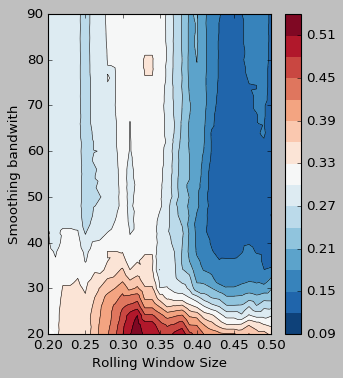

In [48]:
fig, ax = plt.subplots(figsize=(4.5,5))
#fig = plt.figure(figsize=(10,8))
plt.style.use('classic')

#z = list(storage_lag)
#z.insert(0, np.min(storage_lag))
#ax.contour(bw, rw, np.array(z).reshape(30, 38), cmap="RdBu_r")

window, bandwith = zip(*TupList)
x = window[1:]
y = bandwith[1:]
if np.max(storage_std)>np.max(storage_lag):
    z = storage_std
else:
    z= storage_lag
ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
fig.colorbar(cntr, ax=ax)
ax.set(xlim=(0.2, 0.5), ylim=(20, 90))
ax.set_ylabel('Smoothing bandwith', fontsize=12)
ax.set_xlabel('Rolling Window Size', fontsize=12)

foo_fig = plt.gcf()  # 'get current figure'
# set "generateNow" in previous cell
if (generateNow):
    os.chdir(path_written_to)
    foo_fig.savefig((cityname + "-Essential_contour-new.png"))

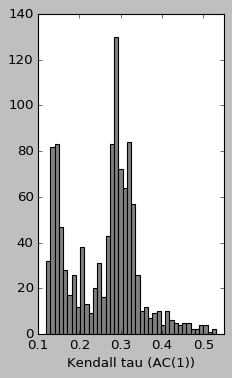

In [34]:
plt.style.use('classic')
fig = plt.figure(figsize=(3,5))

#z = list(storage_lag)
#z.insert(0, np.min(storage_lag))
#ax.contour(bw, rw, np.array(z).reshape(30, 38), cmap="RdBu_r")

if np.max(storage_std)>np.max(storage_lag):
    a = storage_std
    label = 'Std'
else:
    a= storage_lag
    label = 'AC(1)'

hist,bins = np.histogram(a,bins=40)

plt.hist(a, bins = bins, color='grey')

plt.xlabel('Kendall tau (' + label + ')')


foo_fig = plt.gcf()  # 'get current figure'
# set "generateNow" in previous cell
if (generateNow):
    os.chdir(path_written_to)
    foo_fig.savefig((cityname + "-Essential_histogram-new.png"))

## Here starts Non-essential

In [49]:
# reset storage
storage_std = np.array([])
storage_lag = np.array([])
print("should print out two empty brakets below")
print(storage_std)
print(storage_lag)

for i in range(len(TupList)):
    ews_dic = core.ews_compute(cityWhole["NonEssential"], roll_window = TupList[i][0],smooth ='Gaussian',band_width= TupList[i][1],span = span,lag_times = [1], ews = ews,upto = 'Full')
    if i != 0:
        storage_std = np.append( storage_std,ews_dic['Kendall tau']["Standard deviation"][0])
        storage_lag = np.append(storage_lag, ews_dic['Kendall tau']["Lag-1 AC"][0])

should print out two empty brakets below
[]
[]


### I know they can be overriden, but just in case we reset all variables

In [50]:
max_std = -100000000
max_lag = -100000000
max_std = np.amax(storage_std)
max_lag = np.amax(storage_lag)
print(max_std)
print(max_lag)

0.8260869565217392
0.7631822386679002


In [51]:
print(len(TupList))
print(len(storage_std))
print(len(storage_lag))

1116
1115
1115


PLUS 1 SINCE LENGTH IS DIFFERENT

In [52]:
# reset
max_std_index = -10000000
target_pair_std = (-10000000,-100000000)
# compute
print("*** max std located in pair ***")
max_std_index = np.where(storage_std == max_std) # find the largest element index
print("index at : " + str(max_std_index[0] + 1))
target_pair_std = TupList[max_std_index[0][0] + 1]
print("tuple (rowing-windows,bandwidth): " + str(target_pair_std))
print("largest std kendall tau: " + str(max_std))

*** max std located in pair ***
index at : [1080]
tuple (rowing-windows,bandwidth): (0.5, 20.0)
largest std kendall tau: 0.8260869565217392


In [53]:
# reset
max_lag_index = -1000000000
target_pair_lag = (-1000000000,-1000000000)
# compute
print("*** max lag located in pair ***")
max_lag_index = np.where(storage_lag == max_lag)
print("index at : " + str(max_lag_index[0] + 1)) # set to the index zero when multiple results return because we try to have smaller rowing window
target_pair_lag = TupList[max_lag_index[0][0] + 1]
print("tuple (rowing-windows,bandwidth): " + str(target_pair_lag))
print("largest lag kendall tau: " + str(max_lag))

*** max lag located in pair ***
index at : [1080 1081]
tuple (rowing-windows,bandwidth): (0.5, 20.0)
largest lag kendall tau: 0.7631822386679002


In [54]:
selected_pair = ()
if (max_lag > max_std):
    selected_pair = target_pair_lag
    print("lagAC larger, select " + str(target_pair_lag))
elif(max_lag < max_std):
    selected_pair = target_pair_std
    print("std larger, select " + str(target_pair_std))
else:
    print("rare case!")
    selected_pair = target_pair_lag

std larger, select (0.5, 20.0)


In [55]:
setRW = -10000000
setBW = -10000000
setRW = round(selected_pair[0],3)
setBW = selected_pair[1]
print("setRW : " + str(setRW))
print("setBW : " + str(setBW))

setRW : 0.5
setBW : 20.0


In [56]:
ews_dic = core.ews_compute(cityWhole["NonEssential"], 
                          roll_window = setRW,
                           smooth ='Gaussian',
                           band_width=setBW,
                          span = span,
                          lag_times = [1], 
                          ews = ews,
                          upto = 'Full')

In [57]:
setRW = target_pair_std[0]
setBW = target_pair_std[1]
print("setRW : " + str(setRW))
print("setBW : " + str(setBW))

ews_dic_std = core.ews_compute(cityWhole["NonEssential"], 
                          roll_window = setRW,
                           smooth ='Gaussian',
                           band_width= setBW,
                          span = span,
                          lag_times = [1], 
                          ews = ews,
                          upto = 'Full')

setRW : 0.5
setBW : 20.0


In [58]:
setRW = target_pair_lag[0]
setBW = target_pair_lag[1]
print("setRW : " + str(setRW))
print("setBW : " + str(setBW))

ews_dic_lag = core.ews_compute(cityWhole["NonEssential"], 
                          roll_window = setRW,
                           smooth ='Gaussian',
                           band_width= setBW,
                          span = span,
                          lag_times = [1], 
                          ews = ews,
                          upto = 'Full')

setRW : 0.5
setBW : 20.0


In [59]:
# dfs
df_ews_std = ews_dic_std['EWS metrics']
df_ktau_std = ews_dic_std['Kendall tau']

df_ews_lag = ews_dic_lag['EWS metrics']
df_ktau_lag = ews_dic_lag['Kendall tau']

df_ews = ews_dic['EWS metrics']

In [60]:
#  reset
annotation_location_1 = -10000000
annotation_location_2 = -10000000
annotation_location_3 = -10000000
annotation_location_4 = -10000000

# location of annotation for the 1st graph
annotation_location_1 = np.mean(df_ews[["State variable"]])
annotation_location_2 = np.mean(df_ews[["Residuals"]])
# location of annotations for the 2nd graph
annotation_location_3 = np.mean(df_ews_std["Standard deviation"])
# location of annotations for the 3rd graph
annotation_location_4 = np.mean(df_ews_lag["Lag-1 AC"])

In [61]:
# 2 parameter: you may want to change these two
LegendTF = False
generateNow = True

# set the early warning (gray)band using the variables below 

# Action Required: the start and the end of band in first graph
bar_start_1 = 62 # need modification
bar_end_1 = 64 # need modification


# Action Required: the start and the end of band in 2nd graph
bar_start_2 = 74 # need modification
bar_end_2 = 76 # need modification


# Action Required: the start and the end of band in 3rd graph
bar_start_3 = 60 # need modification
bar_end_3 = 62 # need modification

In [62]:
cityWhole.loc[60]

Date            2020-03-01
Essential            76197
NonEssential        287105
Name: 60, dtype: object

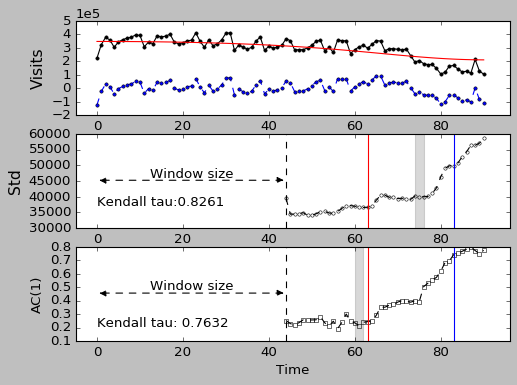

In [63]:
# the dates and string of first case, first death , shelter in place order are set at the beginning in the notebook
# parameter needs to be set are in the previous cell

# constants , you don't need to change them
ZERO = 0
DIST = 5
ALPHA = 0.7
NROWS = 3
NCOLS = 1

# plots
# constant, you don't need to change them, but if you want to you can change ALPHA OR DIST 
ALPHA = 0.3
DIST = 5
ZERO = 0
NROWS = 3
NCOLS = 1
windown_position_std = int(target_pair_std[0]*total_days-1)
windown_position_lag = int(target_pair_lag[0]*total_days-1)
# title = ("Essential Early warning signals for city " + cityname)
# No action require below
plt.style.use('classic')
fig1, axes = plt.subplots(nrows = NROWS, ncols = NCOLS, figsize=(7,5))
df_ews[['State variable']].plot(ax=axes[0], 
        color='black', xlim = (-DIST,total_days + DIST),legend = LegendTF,
        marker='o', markersize=3) # frame auto set
df_ews[['Smoothing']].plot(ax=axes[0], color='red', xlim = (-DIST,total_days + DIST),legend = LegendTF)
df_ews[['Residuals']].plot(ax=axes[0], color='blue', xlim = (-DIST,total_days + DIST),legend = LegendTF,
                            marker='o', markersize=3, linestyle='dashed') # frame auto set
#axes[0].axvline(x = case_num, color='red', label='First case')
#axes[0].axvline(x = death_num, color='yellow')
#axes[0].axvline(x = shelter_num, color='yellow', label='Shelter in place')
#axes[0].annotate('First Case' +'\n'+ first_case, xy=((case_num + DIST), annotation_location_2)) # location auto set
#axes[0].annotate('First Death'+'\n'+ first_death, xy=((death_num - DIST), annotation_location_2)) # location auto set
#axes[0].annotate('Shelter in Place'+'\n'+ shelter, xy=((shelter_num + DIST), annotation_location_1)) # location auto set
#axes[0].axvspan(bar_start_1, bar_end_1, alpha=ALPHA, color='gray')
#axes[0].legend(loc=3, ncol=3)
axes[0].set_ylabel('Visits', fontsize=14)
axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#axes[0].annotate('(d)', xy=(1 - DIST, 0.8*np.max(df_ews[["State variable"]])))




df_ews_std['Standard deviation'].plot(ax=axes[1],legend=False, xlim = (-DIST,total_days+DIST),
                                      color="black", marker='o', markersize=3, ls='--', markerfacecolor='none') # frame auto set
axes[1].axvline(x = case_num, color='red')
#axes[1].axvline(x = death_num, color='purple')
axes[1].axvline(x = shelter_num, color='blue')
axes[1].annotate("Kendall tau:" + str(round(df_ktau_std["Standard deviation"][0],4)), xy=(ZERO, 0.9*annotation_location_3)) # location auto set
#axes[1].annotate('First Case' +'\n'+ first_case, xy=((case_num + DIST), annotation_location_3)) # location auto set
#axes[1].annotate('First Death'+'\n'+ first_death, xy=((death_num - DIST), annotation_location_3)) # location auto set
#axes[1].annotate('Shelter in Place'+'\n'+ shelter, xy=((shelter_num + DIST), annotation_location_3)) # location auto set
axes[1].axvspan(bar_start_2, bar_end_2, alpha = ALPHA, color='gray', label='Early Warning Period')
axes[1].axvline(x = windown_position_std, color='black', ls='--')
axes[1].annotate("", xy=(0, 1.1*annotation_location_3), xytext=(windown_position_std, 1.1*annotation_location_3),
    arrowprops=dict(arrowstyle="<|-|>", connectionstyle="arc3", ls='--',color='black'))
axes[1].text(windown_position_std*0.5, 1.1*annotation_location_3, 'Window size',
            {'color': 'black', 'ha': 'center', 'va': 'bottom'})
#axes[1].legend(loc=2, ncol=1)
axes[1].set_ylabel('Std', fontsize=14)
#axes[1].annotate('(e)', xy=(1 - DIST, 0.9*np.max(df_ews_std[["Standard deviation"]])))




df_ews_lag[['Lag-1 AC']].plot(ax=axes[2],legend=False, xlim = (-DIST,total_days+DIST),
                             color="black", marker='s', markersize=3, ls='--', markerfacecolor='none') # frame auto set
axes[2].axvline(x = case_num, color='red')
#axes[2].axvline(x = death_num, color='purple')
axes[2].axvline(x = shelter_num, color='blue')
axes[2].annotate("Kendall tau: " + str(round(df_ktau_lag["Lag-1 AC"][0],4)),xy=(ZERO, annotation_location_4*0.5)) # location auto set

#axes[2].annotate('First Case' +'\n'+ first_case, xy=((case_num + DIST), annotation_location_4)) # location auto set
#axes[2].annotate('First Death'+'\n'+ first_death, xy=((death_num - DIST), annotation_location_4)) # location auto set
#axes[2].annotate('Shelter in Place'+'\n'+ shelter, xy=((shelter_num + DIST), annotation_location_4)) # location auto set
axes[2].axvspan(bar_start_3, bar_end_3, alpha = ALPHA, color='gray', label='Early Warning Period') 
axes[2].axvline(x = windown_position_lag, color='black', ls='--')
axes[2].annotate("", xy=(0, 1.1*annotation_location_4), xytext=(windown_position_lag, 1.1*annotation_location_4),
    arrowprops=dict(arrowstyle="<|-|>", connectionstyle="arc3", ls='--', color='black'))
axes[2].text(windown_position_lag*0.5, 1.1*annotation_location_4, 'Window size',
            {'color': 'black', 'ha': 'center', 'va': 'bottom'})
#axes[2].legend(loc=2)
axes[2].set_ylabel('AC(1)')
#axes[2].annotate('(f)', xy=(1-DIST, 0.85*np.max(df_ews_lag[["Lag-1 AC"]])))

foo_fig = plt.gcf()  # 'get current figure'


# set "generateNow" in previous cell
if (generateNow):
    os.chdir(path_written_to)
    foo_fig.savefig((cityname + "-NonEssential-new.png"))

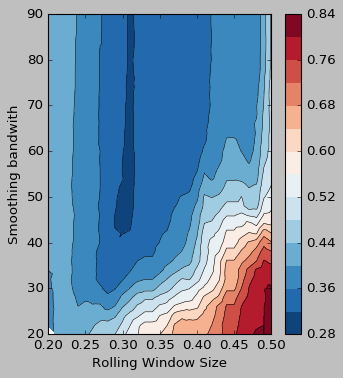

In [64]:
fig, ax = plt.subplots(figsize=(4.5,5))
#fig = plt.figure(figsize=(10,8))
plt.style.use('classic')

#z = list(storage_lag)
#z.insert(0, np.min(storage_lag))
#ax.contour(bw, rw, np.array(z).reshape(30, 38), cmap="RdBu_r")

window, bandwith = zip(*TupList)
x = window[1:]
y = bandwith[1:]
if np.max(storage_std)>np.max(storage_lag):
    z = storage_std
else:
    z= storage_lag
ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
fig.colorbar(cntr, ax=ax)
ax.set(xlim=(0.2, 0.5), ylim=(20, 90))
ax.set_ylabel('Smoothing bandwith', fontsize=12)
ax.set_xlabel('Rolling Window Size', fontsize=12)

foo_fig = plt.gcf()  # 'get current figure'
# set "generateNow" in previous cell
if (generateNow):
    os.chdir(path_written_to)
    foo_fig.savefig((cityname + "-NonEssential_contour-new.png"))

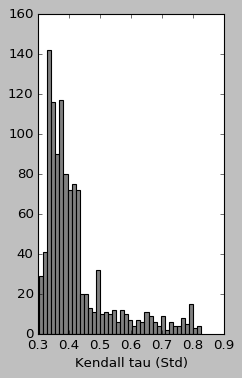

In [65]:
plt.style.use('classic')
fig = plt.figure(figsize=(3,5))

#z = list(storage_lag)
#z.insert(0, np.min(storage_lag))
#ax.contour(bw, rw, np.array(z).reshape(30, 38), cmap="RdBu_r")

if np.max(storage_std)>np.max(storage_lag):
    a = storage_std
    label = 'Std'
else:
    a= storage_lag
    label = 'AC(1)'

hist,bins = np.histogram(a,bins=40)

plt.hist(a, bins = bins, color='grey')

plt.xlabel('Kendall tau (' + label + ')')


foo_fig = plt.gcf()  # 'get current figure'
# set "generateNow" in previous cell
if (generateNow):
    os.chdir(path_written_to)
    foo_fig.savefig((cityname + "-NonEssential_histogram-new.png"))

In [340]:
help(core.ews_compute)

Help on function ews_compute in module ewstools.core:

ews_compute(raw_series, roll_window=0.4, smooth='Lowess', span=0.1, band_width=0.2, upto='Full', ews=['var', 'ac'], lag_times=[1], ham_length=40, ham_offset=0.5, pspec_roll_offset=20, w_cutoff=1, aic=['Fold', 'Hopf', 'Null'], sweep=False)
    Compute temporal and spectral EWS from time-series data.
    
    Args
    ----
    raw_series: pd.Series
        Time-series data to analyse. Indexed by time.
    roll_window: float
        Rolling window size as a proportion of the length of the time-series 
        data.
    smooth: {'Gaussian', 'Lowess', 'None'}
        Type of detrending.
    band_width: float
        Bandwidth of Gaussian kernel. Taken as a proportion of time-series length if in (0,1), 
        otherwise taken as absolute.
    span: float
        Span of time-series data used for Lowess filtering. Taken as a 
        proportion of time-series length if in (0,1), otherwise taken as 
        absolute.
    upto: int or 'Ful